In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.11.0
Default GPU Device: /device:GPU:0


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG: r+(gamma*nextQ)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    rates = tf.reshape(rates, shape=[-1, 1])
#     dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
#                                                                     labels=rates)) # 0-1
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
#     dlossA /= 2
#     dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
#     dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                    model.g_opt, model.d_optA], #, model.d_optQ
                                                   feed_dict = {model.states: states, 
                                                                model.actions: actions,
                                                                model.targetQs: targetQs, 
                                                                model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:20.0000 R:20.0000 rate:0.0400 gloss:0.6750 dlossA:0.5717 dlossQ:1.9685 exploreP:0.9980
Episode:1 meanR:19.5000 R:19.0000 rate:0.0380 gloss:0.6730 dlossA:0.5667 dlossQ:2.0051 exploreP:0.9961
Episode:2 meanR:23.0000 R:30.0000 rate:0.0600 gloss:0.6480 dlossA:0.5511 dlossQ:2.0724 exploreP:0.9932
Episode:3 meanR:20.0000 R:11.0000 rate:0.0220 gloss:0.6410 dlossA:0.5454 dlossQ:2.0997 exploreP:0.9921
Episode:4 meanR:18.8000 R:14.0000 rate:0.0280 gloss:0.6345 dlossA:0.5409 dlossQ:2.1336 exploreP:0.9907
Episode:5 meanR:17.8333 R:13.0000 rate:0.0260 gloss:0.6288 dlossA:0.5381 dlossQ:2.1519 exploreP:0.9895
Episode:6 meanR:18.4286 R:22.0000 rate:0.0440 gloss:0.6212 dlossA:0.5279 dlossQ:2.2195 exploreP:0.9873
Episode:7 meanR:17.5000 R:11.0000 rate:0.0220 gloss:0.6072 dlossA:0.5259 dlossQ:2.1847 exploreP:0.9862
Episode:8 meanR:17.2222 R:15.0000 rate:0.0300 gloss:0.6046 dlossA:0.5304 dlossQ:2.2230 exploreP:0.9848
Episode:9 meanR:17.4000 R:19.0000 rate:0.0380 gloss:0.5922 dlossA:0.5233 

Episode:79 meanR:23.7625 R:19.0000 rate:0.0380 gloss:-0.0995 dlossA:0.4101 dlossQ:3.0780 exploreP:0.8286
Episode:80 meanR:23.7160 R:20.0000 rate:0.0400 gloss:-0.0884 dlossA:0.4040 dlossQ:3.1161 exploreP:0.8270
Episode:81 meanR:24.0122 R:48.0000 rate:0.0960 gloss:-0.0862 dlossA:0.3862 dlossQ:3.0730 exploreP:0.8231
Episode:82 meanR:23.9639 R:20.0000 rate:0.0400 gloss:-0.0760 dlossA:0.3892 dlossQ:3.0838 exploreP:0.8214
Episode:83 meanR:23.9405 R:22.0000 rate:0.0440 gloss:-0.1003 dlossA:0.3791 dlossQ:3.0747 exploreP:0.8197
Episode:84 meanR:23.7647 R:9.0000 rate:0.0180 gloss:-0.0720 dlossA:0.4156 dlossQ:3.1027 exploreP:0.8189
Episode:85 meanR:23.6512 R:14.0000 rate:0.0280 gloss:-0.0999 dlossA:0.3635 dlossQ:3.0509 exploreP:0.8178
Episode:86 meanR:23.6897 R:27.0000 rate:0.0540 gloss:-0.0794 dlossA:0.3790 dlossQ:3.0812 exploreP:0.8156
Episode:87 meanR:23.6591 R:21.0000 rate:0.0420 gloss:-0.0696 dlossA:0.4001 dlossQ:3.4087 exploreP:0.8139
Episode:88 meanR:23.6742 R:25.0000 rate:0.0500 gloss:-0.

Episode:157 meanR:20.2300 R:13.0000 rate:0.0260 gloss:-0.0526 dlossA:0.3722 dlossQ:3.3722 exploreP:0.7164
Episode:158 meanR:20.1900 R:16.0000 rate:0.0320 gloss:-0.0797 dlossA:0.3735 dlossQ:3.2526 exploreP:0.7153
Episode:159 meanR:19.9300 R:15.0000 rate:0.0300 gloss:-0.0509 dlossA:0.3954 dlossQ:3.3576 exploreP:0.7142
Episode:160 meanR:19.9000 R:20.0000 rate:0.0400 gloss:-0.0784 dlossA:0.3797 dlossQ:3.3246 exploreP:0.7128
Episode:161 meanR:19.8600 R:11.0000 rate:0.0220 gloss:-0.0469 dlossA:0.3778 dlossQ:3.3620 exploreP:0.7121
Episode:162 meanR:19.7900 R:14.0000 rate:0.0280 gloss:-0.0568 dlossA:0.3665 dlossQ:3.3696 exploreP:0.7111
Episode:163 meanR:19.7400 R:11.0000 rate:0.0220 gloss:-0.0491 dlossA:0.3833 dlossQ:3.4743 exploreP:0.7103
Episode:164 meanR:19.4200 R:9.0000 rate:0.0180 gloss:-0.0895 dlossA:0.3590 dlossQ:3.2436 exploreP:0.7097
Episode:165 meanR:19.3300 R:8.0000 rate:0.0160 gloss:-0.0355 dlossA:0.3993 dlossQ:3.5164 exploreP:0.7091
Episode:166 meanR:19.4600 R:27.0000 rate:0.0540 

Episode:235 meanR:15.4000 R:13.0000 rate:0.0260 gloss:-0.0103 dlossA:0.3701 dlossQ:3.6300 exploreP:0.6393
Episode:236 meanR:15.4700 R:19.0000 rate:0.0380 gloss:-0.0373 dlossA:0.3891 dlossQ:3.5764 exploreP:0.6381
Episode:237 meanR:15.2500 R:10.0000 rate:0.0200 gloss:-0.0587 dlossA:0.4051 dlossQ:3.4958 exploreP:0.6375
Episode:238 meanR:15.2000 R:14.0000 rate:0.0280 gloss:-0.0332 dlossA:0.3962 dlossQ:3.5363 exploreP:0.6366
Episode:239 meanR:15.1700 R:15.0000 rate:0.0300 gloss:-0.0039 dlossA:0.3880 dlossQ:3.6268 exploreP:0.6357
Episode:240 meanR:15.1900 R:14.0000 rate:0.0280 gloss:-0.0274 dlossA:0.3725 dlossQ:3.5525 exploreP:0.6348
Episode:241 meanR:14.9800 R:22.0000 rate:0.0440 gloss:0.0373 dlossA:0.3948 dlossQ:3.8269 exploreP:0.6334
Episode:242 meanR:15.1800 R:28.0000 rate:0.0560 gloss:0.0160 dlossA:0.3929 dlossQ:3.7139 exploreP:0.6317
Episode:243 meanR:15.1600 R:12.0000 rate:0.0240 gloss:-0.0249 dlossA:0.3927 dlossQ:3.5743 exploreP:0.6309
Episode:244 meanR:15.2200 R:19.0000 rate:0.0380 

Episode:313 meanR:15.1400 R:25.0000 rate:0.0500 gloss:-0.0009 dlossA:0.4052 dlossQ:3.7042 exploreP:0.5680
Episode:314 meanR:15.1200 R:10.0000 rate:0.0200 gloss:0.0561 dlossA:0.3583 dlossQ:3.8771 exploreP:0.5675
Episode:315 meanR:15.1200 R:16.0000 rate:0.0320 gloss:0.0182 dlossA:0.4065 dlossQ:3.7473 exploreP:0.5666
Episode:316 meanR:15.1000 R:12.0000 rate:0.0240 gloss:0.0042 dlossA:0.3890 dlossQ:3.6855 exploreP:0.5659
Episode:317 meanR:15.0400 R:11.0000 rate:0.0220 gloss:0.0236 dlossA:0.3958 dlossQ:3.7787 exploreP:0.5653
Episode:318 meanR:14.9500 R:16.0000 rate:0.0320 gloss:0.0260 dlossA:0.3732 dlossQ:3.7676 exploreP:0.5644
Episode:319 meanR:15.0800 R:23.0000 rate:0.0460 gloss:0.0198 dlossA:0.3833 dlossQ:3.7320 exploreP:0.5631
Episode:320 meanR:15.0600 R:9.0000 rate:0.0180 gloss:0.0105 dlossA:0.4071 dlossQ:3.7039 exploreP:0.5626
Episode:321 meanR:15.1300 R:21.0000 rate:0.0420 gloss:0.0400 dlossA:0.3789 dlossQ:3.7918 exploreP:0.5615
Episode:322 meanR:15.0900 R:12.0000 rate:0.0240 gloss:-

Episode:391 meanR:14.2700 R:13.0000 rate:0.0260 gloss:0.0286 dlossA:0.3859 dlossQ:3.8188 exploreP:0.5123
Episode:392 meanR:14.1100 R:10.0000 rate:0.0200 gloss:-0.0119 dlossA:0.3800 dlossQ:3.7101 exploreP:0.5118
Episode:393 meanR:14.0300 R:14.0000 rate:0.0280 gloss:-0.0196 dlossA:0.3443 dlossQ:3.7281 exploreP:0.5110
Episode:394 meanR:14.1400 R:22.0000 rate:0.0440 gloss:0.0058 dlossA:0.3764 dlossQ:3.8446 exploreP:0.5099
Episode:395 meanR:14.1300 R:12.0000 rate:0.0240 gloss:-0.0096 dlossA:0.3939 dlossQ:3.8081 exploreP:0.5093
Episode:396 meanR:14.1100 R:12.0000 rate:0.0240 gloss:-0.0216 dlossA:0.3988 dlossQ:3.7016 exploreP:0.5087
Episode:397 meanR:14.1100 R:14.0000 rate:0.0280 gloss:-0.0344 dlossA:0.3697 dlossQ:3.6727 exploreP:0.5081
Episode:398 meanR:14.0200 R:18.0000 rate:0.0360 gloss:-0.0143 dlossA:0.3871 dlossQ:3.7098 exploreP:0.5072
Episode:399 meanR:14.0700 R:19.0000 rate:0.0380 gloss:0.0009 dlossA:0.3761 dlossQ:3.7704 exploreP:0.5062
Episode:400 meanR:14.0100 R:12.0000 rate:0.0240 g

Episode:469 meanR:12.7500 R:12.0000 rate:0.0240 gloss:-0.0083 dlossA:0.3864 dlossQ:3.7963 exploreP:0.4652
Episode:470 meanR:12.7200 R:14.0000 rate:0.0280 gloss:0.0148 dlossA:0.3889 dlossQ:3.8136 exploreP:0.4646
Episode:471 meanR:12.6500 R:9.0000 rate:0.0180 gloss:0.0596 dlossA:0.3669 dlossQ:3.9969 exploreP:0.4642
Episode:472 meanR:12.6300 R:9.0000 rate:0.0180 gloss:-0.0031 dlossA:0.3887 dlossQ:3.7886 exploreP:0.4638
Episode:473 meanR:12.6200 R:11.0000 rate:0.0220 gloss:-0.0051 dlossA:0.3411 dlossQ:3.8097 exploreP:0.4633
Episode:474 meanR:12.7000 R:21.0000 rate:0.0420 gloss:0.0183 dlossA:0.3886 dlossQ:3.9301 exploreP:0.4623
Episode:475 meanR:12.7100 R:13.0000 rate:0.0260 gloss:0.0216 dlossA:0.3911 dlossQ:3.9151 exploreP:0.4617
Episode:476 meanR:12.6900 R:9.0000 rate:0.0180 gloss:-0.0098 dlossA:0.3518 dlossQ:3.8251 exploreP:0.4613
Episode:477 meanR:12.7500 R:16.0000 rate:0.0320 gloss:-0.0112 dlossA:0.3585 dlossQ:3.8173 exploreP:0.4606
Episode:478 meanR:12.7300 R:9.0000 rate:0.0180 gloss:

Episode:547 meanR:12.9700 R:10.0000 rate:0.0200 gloss:0.0265 dlossA:0.3875 dlossQ:4.0162 exploreP:0.4211
Episode:548 meanR:12.9700 R:13.0000 rate:0.0260 gloss:0.0021 dlossA:0.3614 dlossQ:3.9144 exploreP:0.4206
Episode:549 meanR:12.9800 R:12.0000 rate:0.0240 gloss:0.0228 dlossA:0.4029 dlossQ:3.9418 exploreP:0.4201
Episode:550 meanR:12.9800 R:13.0000 rate:0.0260 gloss:0.0000 dlossA:0.3715 dlossQ:3.9312 exploreP:0.4196
Episode:551 meanR:13.0000 R:11.0000 rate:0.0220 gloss:-0.0253 dlossA:0.3471 dlossQ:3.8776 exploreP:0.4191
Episode:552 meanR:12.9600 R:10.0000 rate:0.0200 gloss:-0.0144 dlossA:0.3766 dlossQ:3.8770 exploreP:0.4187
Episode:553 meanR:12.9500 R:10.0000 rate:0.0200 gloss:-0.0125 dlossA:0.3884 dlossQ:3.8532 exploreP:0.4183
Episode:554 meanR:12.9800 R:15.0000 rate:0.0300 gloss:0.0088 dlossA:0.3894 dlossQ:3.9747 exploreP:0.4177
Episode:555 meanR:12.9600 R:13.0000 rate:0.0260 gloss:-0.0083 dlossA:0.3996 dlossQ:3.8729 exploreP:0.4172
Episode:556 meanR:12.9900 R:13.0000 rate:0.0260 glo

Episode:625 meanR:12.8200 R:25.0000 rate:0.0500 gloss:-0.0005 dlossA:0.3938 dlossQ:3.8356 exploreP:0.3826
Episode:626 meanR:12.8500 R:12.0000 rate:0.0240 gloss:0.0096 dlossA:0.3800 dlossQ:3.8948 exploreP:0.3822
Episode:627 meanR:12.8600 R:12.0000 rate:0.0240 gloss:0.0282 dlossA:0.3914 dlossQ:3.9721 exploreP:0.3817
Episode:628 meanR:12.8300 R:13.0000 rate:0.0260 gloss:0.0153 dlossA:0.3556 dlossQ:3.9698 exploreP:0.3813
Episode:629 meanR:12.8000 R:13.0000 rate:0.0260 gloss:-0.0072 dlossA:0.3546 dlossQ:3.8585 exploreP:0.3808
Episode:630 meanR:12.8200 R:11.0000 rate:0.0220 gloss:0.0072 dlossA:0.3604 dlossQ:3.9133 exploreP:0.3804
Episode:631 meanR:12.7800 R:11.0000 rate:0.0220 gloss:0.0297 dlossA:0.4007 dlossQ:3.9850 exploreP:0.3800
Episode:632 meanR:12.6400 R:10.0000 rate:0.0200 gloss:0.0087 dlossA:0.3722 dlossQ:3.9225 exploreP:0.3796
Episode:633 meanR:12.5900 R:10.0000 rate:0.0200 gloss:0.0029 dlossA:0.3813 dlossQ:3.8624 exploreP:0.3792
Episode:634 meanR:12.5800 R:9.0000 rate:0.0180 gloss:

Episode:703 meanR:11.9400 R:16.0000 rate:0.0320 gloss:-0.0075 dlossA:0.3613 dlossQ:3.9069 exploreP:0.3497
Episode:704 meanR:11.9000 R:8.0000 rate:0.0160 gloss:-0.0140 dlossA:0.3314 dlossQ:3.9568 exploreP:0.3495
Episode:705 meanR:11.8500 R:9.0000 rate:0.0180 gloss:-0.0220 dlossA:0.3770 dlossQ:3.8435 exploreP:0.3492
Episode:706 meanR:11.8600 R:15.0000 rate:0.0300 gloss:0.0009 dlossA:0.3615 dlossQ:4.0033 exploreP:0.3487
Episode:707 meanR:11.8500 R:11.0000 rate:0.0220 gloss:-0.0228 dlossA:0.3743 dlossQ:3.9259 exploreP:0.3483
Episode:708 meanR:11.8200 R:9.0000 rate:0.0180 gloss:-0.0209 dlossA:0.3734 dlossQ:3.9121 exploreP:0.3480
Episode:709 meanR:11.8100 R:11.0000 rate:0.0220 gloss:-0.0337 dlossA:0.3545 dlossQ:3.8890 exploreP:0.3476
Episode:710 meanR:11.7900 R:12.0000 rate:0.0240 gloss:-0.0149 dlossA:0.3516 dlossQ:3.9279 exploreP:0.3472
Episode:711 meanR:11.8100 R:11.0000 rate:0.0220 gloss:0.0234 dlossA:0.3559 dlossQ:4.0698 exploreP:0.3468
Episode:712 meanR:11.8500 R:12.0000 rate:0.0240 glo

Episode:781 meanR:11.5600 R:13.0000 rate:0.0260 gloss:-0.0007 dlossA:0.3394 dlossQ:4.0440 exploreP:0.3211
Episode:782 meanR:11.5600 R:12.0000 rate:0.0240 gloss:0.0149 dlossA:0.3870 dlossQ:3.9953 exploreP:0.3207
Episode:783 meanR:11.5900 R:12.0000 rate:0.0240 gloss:-0.0217 dlossA:0.3619 dlossQ:3.9114 exploreP:0.3204
Episode:784 meanR:11.5100 R:9.0000 rate:0.0180 gloss:-0.0470 dlossA:0.3720 dlossQ:3.7446 exploreP:0.3201
Episode:785 meanR:11.5300 R:12.0000 rate:0.0240 gloss:0.0242 dlossA:0.3615 dlossQ:4.0547 exploreP:0.3197
Episode:786 meanR:11.5600 R:13.0000 rate:0.0260 gloss:0.0135 dlossA:0.3549 dlossQ:3.8657 exploreP:0.3193
Episode:787 meanR:11.5300 R:14.0000 rate:0.0280 gloss:-0.0015 dlossA:0.3944 dlossQ:3.9345 exploreP:0.3189
Episode:788 meanR:11.5000 R:12.0000 rate:0.0240 gloss:-0.0203 dlossA:0.3759 dlossQ:3.8885 exploreP:0.3185
Episode:789 meanR:11.4500 R:9.0000 rate:0.0180 gloss:0.0060 dlossA:0.3873 dlossQ:3.9775 exploreP:0.3182
Episode:790 meanR:11.4400 R:9.0000 rate:0.0180 gloss

Episode:859 meanR:11.0600 R:9.0000 rate:0.0180 gloss:-0.0010 dlossA:0.3443 dlossQ:3.7770 exploreP:0.2956
Episode:860 meanR:11.0700 R:12.0000 rate:0.0240 gloss:-0.0138 dlossA:0.3547 dlossQ:3.7814 exploreP:0.2953
Episode:861 meanR:11.0600 R:9.0000 rate:0.0180 gloss:0.0408 dlossA:0.3861 dlossQ:3.9167 exploreP:0.2950
Episode:862 meanR:11.0700 R:10.0000 rate:0.0200 gloss:-0.0087 dlossA:0.3479 dlossQ:3.7334 exploreP:0.2947
Episode:863 meanR:11.1000 R:14.0000 rate:0.0280 gloss:-0.0160 dlossA:0.3338 dlossQ:3.9023 exploreP:0.2943
Episode:864 meanR:11.0900 R:9.0000 rate:0.0180 gloss:0.0023 dlossA:0.3680 dlossQ:3.9443 exploreP:0.2941
Episode:865 meanR:11.0500 R:10.0000 rate:0.0200 gloss:-0.0108 dlossA:0.3789 dlossQ:3.9144 exploreP:0.2938
Episode:866 meanR:11.0000 R:11.0000 rate:0.0220 gloss:-0.0270 dlossA:0.3428 dlossQ:3.9171 exploreP:0.2935
Episode:867 meanR:11.0000 R:10.0000 rate:0.0200 gloss:-0.0211 dlossA:0.3564 dlossQ:3.8377 exploreP:0.2932
Episode:868 meanR:10.9900 R:9.0000 rate:0.0180 glos

Episode:937 meanR:11.1500 R:14.0000 rate:0.0280 gloss:0.0020 dlossA:0.3443 dlossQ:3.9628 exploreP:0.2718
Episode:938 meanR:11.1400 R:10.0000 rate:0.0200 gloss:-0.0504 dlossA:0.4029 dlossQ:3.7463 exploreP:0.2715
Episode:939 meanR:11.0900 R:10.0000 rate:0.0200 gloss:-0.0378 dlossA:0.3641 dlossQ:3.8429 exploreP:0.2713
Episode:940 meanR:11.1200 R:13.0000 rate:0.0260 gloss:-0.0551 dlossA:0.3616 dlossQ:3.7103 exploreP:0.2709
Episode:941 meanR:11.1000 R:10.0000 rate:0.0200 gloss:-0.0595 dlossA:0.3483 dlossQ:3.8087 exploreP:0.2707
Episode:942 meanR:11.1000 R:12.0000 rate:0.0240 gloss:-0.0373 dlossA:0.3666 dlossQ:3.8430 exploreP:0.2704
Episode:943 meanR:11.0800 R:9.0000 rate:0.0180 gloss:-0.0675 dlossA:0.3424 dlossQ:3.7479 exploreP:0.2701
Episode:944 meanR:11.0900 R:12.0000 rate:0.0240 gloss:-0.0377 dlossA:0.3622 dlossQ:3.7840 exploreP:0.2698
Episode:945 meanR:11.0900 R:10.0000 rate:0.0200 gloss:-0.0588 dlossA:0.3354 dlossQ:3.8643 exploreP:0.2696
Episode:946 meanR:11.0900 R:11.0000 rate:0.0220 

Episode:1015 meanR:11.0800 R:12.0000 rate:0.0240 gloss:-0.0746 dlossA:0.3768 dlossQ:3.7744 exploreP:0.2502
Episode:1016 meanR:11.1000 R:11.0000 rate:0.0220 gloss:-0.1372 dlossA:0.3537 dlossQ:3.7477 exploreP:0.2500
Episode:1017 meanR:11.1100 R:12.0000 rate:0.0240 gloss:-0.0654 dlossA:0.3565 dlossQ:3.8360 exploreP:0.2497
Episode:1018 meanR:11.1100 R:11.0000 rate:0.0220 gloss:-0.0842 dlossA:0.3648 dlossQ:3.8720 exploreP:0.2494
Episode:1019 meanR:11.0600 R:10.0000 rate:0.0200 gloss:-0.1086 dlossA:0.3706 dlossQ:3.8254 exploreP:0.2492
Episode:1020 meanR:11.0800 R:12.0000 rate:0.0240 gloss:-0.0366 dlossA:0.3762 dlossQ:3.9191 exploreP:0.2489
Episode:1021 meanR:11.0800 R:10.0000 rate:0.0200 gloss:-0.1061 dlossA:0.3921 dlossQ:3.7106 exploreP:0.2487
Episode:1022 meanR:11.0500 R:9.0000 rate:0.0180 gloss:-0.0797 dlossA:0.3622 dlossQ:3.7857 exploreP:0.2484
Episode:1023 meanR:11.0100 R:8.0000 rate:0.0160 gloss:-0.1170 dlossA:0.3708 dlossQ:3.7610 exploreP:0.2482
Episode:1024 meanR:11.0000 R:12.0000 ra

Episode:1092 meanR:10.9500 R:9.0000 rate:0.0180 gloss:-0.0237 dlossA:0.4214 dlossQ:3.7430 exploreP:0.2307
Episode:1093 meanR:10.9400 R:9.0000 rate:0.0180 gloss:-0.1226 dlossA:0.3481 dlossQ:3.8894 exploreP:0.2305
Episode:1094 meanR:10.8900 R:11.0000 rate:0.0220 gloss:-0.1306 dlossA:0.3535 dlossQ:3.7922 exploreP:0.2303
Episode:1095 meanR:10.8700 R:10.0000 rate:0.0200 gloss:-0.0851 dlossA:0.3441 dlossQ:3.9105 exploreP:0.2301
Episode:1096 meanR:10.9300 R:15.0000 rate:0.0300 gloss:-0.0171 dlossA:0.3709 dlossQ:3.9376 exploreP:0.2297
Episode:1097 meanR:10.9900 R:14.0000 rate:0.0280 gloss:-0.1443 dlossA:0.3547 dlossQ:3.8223 exploreP:0.2294
Episode:1098 meanR:11.0000 R:10.0000 rate:0.0200 gloss:-0.1263 dlossA:0.3663 dlossQ:3.8476 exploreP:0.2292
Episode:1099 meanR:11.0000 R:10.0000 rate:0.0200 gloss:0.0424 dlossA:0.3297 dlossQ:3.9945 exploreP:0.2290
Episode:1100 meanR:11.0000 R:10.0000 rate:0.0200 gloss:-0.1585 dlossA:0.3311 dlossQ:3.8651 exploreP:0.2288
Episode:1101 meanR:11.0000 R:9.0000 rate

Episode:1169 meanR:10.6400 R:10.0000 rate:0.0200 gloss:-0.1464 dlossA:0.3696 dlossQ:3.8295 exploreP:0.2132
Episode:1170 meanR:10.7200 R:18.0000 rate:0.0360 gloss:-0.3456 dlossA:0.3686 dlossQ:3.8159 exploreP:0.2128
Episode:1171 meanR:10.6900 R:9.0000 rate:0.0180 gloss:-0.2029 dlossA:0.3819 dlossQ:3.8176 exploreP:0.2127
Episode:1172 meanR:10.6800 R:10.0000 rate:0.0200 gloss:-0.1586 dlossA:0.3831 dlossQ:3.9028 exploreP:0.2125
Episode:1173 meanR:10.6800 R:12.0000 rate:0.0240 gloss:-0.2157 dlossA:0.3573 dlossQ:3.8370 exploreP:0.2122
Episode:1174 meanR:10.6600 R:10.0000 rate:0.0200 gloss:-0.1932 dlossA:0.3570 dlossQ:3.6694 exploreP:0.2120
Episode:1175 meanR:10.6600 R:10.0000 rate:0.0200 gloss:-0.1595 dlossA:0.3241 dlossQ:4.0349 exploreP:0.2118
Episode:1176 meanR:10.6700 R:10.0000 rate:0.0200 gloss:-0.2305 dlossA:0.3650 dlossQ:3.9190 exploreP:0.2116
Episode:1177 meanR:10.6600 R:9.0000 rate:0.0180 gloss:-0.3418 dlossA:0.3515 dlossQ:3.8092 exploreP:0.2114
Episode:1178 meanR:10.6600 R:10.0000 ra

Episode:1246 meanR:10.5900 R:12.0000 rate:0.0240 gloss:-1.1227 dlossA:0.3959 dlossQ:3.7894 exploreP:0.1974
Episode:1247 meanR:10.5100 R:10.0000 rate:0.0200 gloss:-0.1355 dlossA:0.3459 dlossQ:4.0287 exploreP:0.1972
Episode:1248 meanR:10.5200 R:11.0000 rate:0.0220 gloss:-0.3457 dlossA:0.3278 dlossQ:3.9857 exploreP:0.1970
Episode:1249 meanR:10.4800 R:9.0000 rate:0.0180 gloss:-0.3489 dlossA:0.4094 dlossQ:3.7993 exploreP:0.1968
Episode:1250 meanR:10.4600 R:9.0000 rate:0.0180 gloss:-0.3441 dlossA:0.4045 dlossQ:3.8525 exploreP:0.1966
Episode:1251 meanR:10.4900 R:11.0000 rate:0.0220 gloss:-0.3018 dlossA:0.3746 dlossQ:4.0096 exploreP:0.1964
Episode:1252 meanR:10.4900 R:9.0000 rate:0.0180 gloss:-0.2800 dlossA:0.3117 dlossQ:4.0203 exploreP:0.1963
Episode:1253 meanR:10.5100 R:14.0000 rate:0.0280 gloss:-0.2295 dlossA:0.3535 dlossQ:3.9591 exploreP:0.1960
Episode:1254 meanR:10.4800 R:8.0000 rate:0.0160 gloss:-0.3681 dlossA:0.3953 dlossQ:3.7969 exploreP:0.1959
Episode:1255 meanR:10.4800 R:11.0000 rate

Episode:1323 meanR:10.5100 R:9.0000 rate:0.0180 gloss:0.0278 dlossA:0.4031 dlossQ:3.8600 exploreP:0.1829
Episode:1324 meanR:10.5200 R:9.0000 rate:0.0180 gloss:0.1099 dlossA:0.3627 dlossQ:4.0448 exploreP:0.1827
Episode:1325 meanR:10.5100 R:10.0000 rate:0.0200 gloss:0.0196 dlossA:0.3456 dlossQ:3.9998 exploreP:0.1826
Episode:1326 meanR:10.5300 R:10.0000 rate:0.0200 gloss:0.0911 dlossA:0.3952 dlossQ:3.9416 exploreP:0.1824
Episode:1327 meanR:10.5400 R:10.0000 rate:0.0200 gloss:-0.0680 dlossA:0.3234 dlossQ:3.9521 exploreP:0.1822
Episode:1328 meanR:10.5700 R:14.0000 rate:0.0280 gloss:0.3032 dlossA:0.3979 dlossQ:4.0149 exploreP:0.1820
Episode:1329 meanR:10.4800 R:9.0000 rate:0.0180 gloss:0.2850 dlossA:0.3622 dlossQ:4.1401 exploreP:0.1818
Episode:1330 meanR:10.5000 R:10.0000 rate:0.0200 gloss:0.1120 dlossA:0.3188 dlossQ:4.1044 exploreP:0.1816
Episode:1331 meanR:10.4900 R:10.0000 rate:0.0200 gloss:0.1830 dlossA:0.3779 dlossQ:4.0003 exploreP:0.1815
Episode:1332 meanR:10.4800 R:9.0000 rate:0.0180 

Episode:1401 meanR:10.3200 R:10.0000 rate:0.0200 gloss:-1.5880 dlossA:0.3569 dlossQ:3.5454 exploreP:0.1695
Episode:1402 meanR:10.3300 R:11.0000 rate:0.0220 gloss:-1.2495 dlossA:0.3673 dlossQ:3.6202 exploreP:0.1693
Episode:1403 meanR:10.3500 R:14.0000 rate:0.0280 gloss:-1.5208 dlossA:0.3690 dlossQ:3.5396 exploreP:0.1691
Episode:1404 meanR:10.3400 R:9.0000 rate:0.0180 gloss:-1.4363 dlossA:0.3955 dlossQ:3.4554 exploreP:0.1690
Episode:1405 meanR:10.3600 R:14.0000 rate:0.0280 gloss:-1.9292 dlossA:0.3747 dlossQ:3.3936 exploreP:0.1687
Episode:1406 meanR:10.3800 R:14.0000 rate:0.0280 gloss:-1.4054 dlossA:0.3360 dlossQ:3.6653 exploreP:0.1685
Episode:1407 meanR:10.3900 R:11.0000 rate:0.0220 gloss:-1.7541 dlossA:0.3451 dlossQ:3.5703 exploreP:0.1683
Episode:1408 meanR:10.3800 R:8.0000 rate:0.0160 gloss:-2.0334 dlossA:0.3847 dlossQ:3.4134 exploreP:0.1682
Episode:1409 meanR:10.3500 R:10.0000 rate:0.0200 gloss:-1.8757 dlossA:0.3461 dlossQ:3.5628 exploreP:0.1681
Episode:1410 meanR:10.3400 R:10.0000 ra

Episode:1478 meanR:10.4900 R:9.0000 rate:0.0180 gloss:-35.7428 dlossA:0.3630 dlossQ:1.1073 exploreP:0.1571
Episode:1479 meanR:10.4900 R:11.0000 rate:0.0220 gloss:-22.1909 dlossA:0.3760 dlossQ:1.4410 exploreP:0.1569
Episode:1480 meanR:10.4800 R:10.0000 rate:0.0200 gloss:-31.1385 dlossA:0.4069 dlossQ:1.1541 exploreP:0.1568
Episode:1481 meanR:10.4700 R:11.0000 rate:0.0220 gloss:-36.8044 dlossA:0.3318 dlossQ:1.2041 exploreP:0.1566
Episode:1482 meanR:10.4600 R:9.0000 rate:0.0180 gloss:-46.9496 dlossA:0.3497 dlossQ:0.9945 exploreP:0.1565
Episode:1483 meanR:10.4900 R:12.0000 rate:0.0240 gloss:-30.0476 dlossA:0.3807 dlossQ:1.1360 exploreP:0.1563
Episode:1484 meanR:10.4900 R:9.0000 rate:0.0180 gloss:-23.5028 dlossA:0.3235 dlossQ:1.5658 exploreP:0.1562
Episode:1485 meanR:10.4900 R:10.0000 rate:0.0200 gloss:-34.3257 dlossA:0.3517 dlossQ:1.1532 exploreP:0.1560
Episode:1486 meanR:10.4700 R:13.0000 rate:0.0260 gloss:-33.6986 dlossA:0.3480 dlossQ:1.2814 exploreP:0.1558
Episode:1487 meanR:10.4700 R:9.

Episode:1554 meanR:10.3400 R:15.0000 rate:0.0300 gloss:-293.6445 dlossA:0.3589 dlossQ:10.5573 exploreP:0.1460
Episode:1555 meanR:10.3400 R:8.0000 rate:0.0160 gloss:-363.2065 dlossA:0.4276 dlossQ:13.4970 exploreP:0.1459
Episode:1556 meanR:10.3600 R:12.0000 rate:0.0240 gloss:-265.9845 dlossA:0.3487 dlossQ:9.8460 exploreP:0.1458
Episode:1557 meanR:10.3400 R:8.0000 rate:0.0160 gloss:-229.6548 dlossA:0.2725 dlossQ:9.3863 exploreP:0.1457
Episode:1558 meanR:10.3500 R:10.0000 rate:0.0200 gloss:-329.6362 dlossA:0.3143 dlossQ:13.2382 exploreP:0.1455
Episode:1559 meanR:10.3200 R:8.0000 rate:0.0160 gloss:-437.9434 dlossA:0.3505 dlossQ:19.0961 exploreP:0.1454
Episode:1560 meanR:10.3500 R:14.0000 rate:0.0280 gloss:-248.6508 dlossA:0.3331 dlossQ:9.9164 exploreP:0.1452
Episode:1561 meanR:10.3100 R:11.0000 rate:0.0220 gloss:-311.1036 dlossA:0.3705 dlossQ:12.7455 exploreP:0.1451
Episode:1562 meanR:10.3000 R:8.0000 rate:0.0160 gloss:-332.1137 dlossA:0.3827 dlossQ:14.5155 exploreP:0.1450
Episode:1563 mean

Episode:1629 meanR:10.0800 R:9.0000 rate:0.0180 gloss:-1595.3647 dlossA:0.4079 dlossQ:132.0297 exploreP:0.1363
Episode:1630 meanR:10.0700 R:9.0000 rate:0.0180 gloss:-1396.5634 dlossA:0.3558 dlossQ:120.7968 exploreP:0.1361
Episode:1631 meanR:10.0700 R:12.0000 rate:0.0240 gloss:-1427.5594 dlossA:0.3186 dlossQ:126.3922 exploreP:0.1360
Episode:1632 meanR:10.0700 R:9.0000 rate:0.0180 gloss:-958.3531 dlossA:0.3219 dlossQ:92.4122 exploreP:0.1359
Episode:1633 meanR:10.0500 R:11.0000 rate:0.0220 gloss:-1761.1733 dlossA:0.3900 dlossQ:154.8998 exploreP:0.1357
Episode:1634 meanR:10.0100 R:10.0000 rate:0.0200 gloss:-1568.5107 dlossA:0.4125 dlossQ:136.7158 exploreP:0.1356
Episode:1635 meanR:10.0300 R:10.0000 rate:0.0200 gloss:-1834.1633 dlossA:0.3366 dlossQ:160.3848 exploreP:0.1355
Episode:1636 meanR:10.0300 R:10.0000 rate:0.0200 gloss:-1184.0081 dlossA:0.3204 dlossQ:110.6314 exploreP:0.1354
Episode:1637 meanR:10.0400 R:10.0000 rate:0.0200 gloss:-991.8002 dlossA:0.3593 dlossQ:95.2324 exploreP:0.1352

Episode:1703 meanR:10.1600 R:9.0000 rate:0.0180 gloss:-4717.5952 dlossA:0.3843 dlossQ:568.9570 exploreP:0.1271
Episode:1704 meanR:10.1800 R:11.0000 rate:0.0220 gloss:-4090.1375 dlossA:0.3862 dlossQ:506.7008 exploreP:0.1269
Episode:1705 meanR:10.2100 R:12.0000 rate:0.0240 gloss:-5449.8784 dlossA:0.3495 dlossQ:620.6894 exploreP:0.1268
Episode:1706 meanR:10.2200 R:10.0000 rate:0.0200 gloss:-5100.6484 dlossA:0.3891 dlossQ:593.9728 exploreP:0.1267
Episode:1707 meanR:10.2200 R:10.0000 rate:0.0200 gloss:-5182.2871 dlossA:0.3716 dlossQ:604.9554 exploreP:0.1265
Episode:1708 meanR:10.1800 R:8.0000 rate:0.0160 gloss:-4927.3750 dlossA:0.2956 dlossQ:623.1088 exploreP:0.1265
Episode:1709 meanR:10.1500 R:9.0000 rate:0.0180 gloss:-4810.3057 dlossA:0.3612 dlossQ:586.7983 exploreP:0.1264
Episode:1710 meanR:10.1500 R:9.0000 rate:0.0180 gloss:-4359.0967 dlossA:0.3616 dlossQ:560.5898 exploreP:0.1262
Episode:1711 meanR:10.1700 R:11.0000 rate:0.0220 gloss:-5079.9736 dlossA:0.3710 dlossQ:634.9224 exploreP:0.1

Episode:1777 meanR:10.0900 R:9.0000 rate:0.0180 gloss:-11273.0869 dlossA:0.3482 dlossQ:1575.6324 exploreP:0.1187
Episode:1778 meanR:10.0300 R:8.0000 rate:0.0160 gloss:-12482.7266 dlossA:0.3617 dlossQ:1745.3811 exploreP:0.1186
Episode:1779 meanR:10.0500 R:11.0000 rate:0.0220 gloss:-10722.4707 dlossA:0.3449 dlossQ:1581.8143 exploreP:0.1185
Episode:1780 meanR:10.0400 R:9.0000 rate:0.0180 gloss:-11083.3105 dlossA:0.3671 dlossQ:1546.8591 exploreP:0.1184
Episode:1781 meanR:10.0500 R:11.0000 rate:0.0220 gloss:-10924.6143 dlossA:0.3513 dlossQ:1561.8632 exploreP:0.1183
Episode:1782 meanR:9.9800 R:8.0000 rate:0.0160 gloss:-13130.4043 dlossA:0.3953 dlossQ:1801.3132 exploreP:0.1182
Episode:1783 meanR:9.9500 R:10.0000 rate:0.0200 gloss:-11166.9600 dlossA:0.3526 dlossQ:1664.7461 exploreP:0.1181
Episode:1784 meanR:9.9700 R:12.0000 rate:0.0240 gloss:-12865.1826 dlossA:0.3976 dlossQ:1792.0614 exploreP:0.1180
Episode:1785 meanR:9.9500 R:8.0000 rate:0.0160 gloss:-8203.6592 dlossA:0.2970 dlossQ:1423.8822 

Episode:1850 meanR:9.8900 R:10.0000 rate:0.0200 gloss:-29190.2910 dlossA:0.3057 dlossQ:4684.5503 exploreP:0.1112
Episode:1851 meanR:9.9000 R:11.0000 rate:0.0220 gloss:-27697.3867 dlossA:0.3702 dlossQ:4411.4604 exploreP:0.1111
Episode:1852 meanR:9.8900 R:9.0000 rate:0.0180 gloss:-28500.6992 dlossA:0.3538 dlossQ:4534.4946 exploreP:0.1110
Episode:1853 meanR:9.8900 R:11.0000 rate:0.0220 gloss:-26464.2832 dlossA:0.3847 dlossQ:4482.6260 exploreP:0.1109
Episode:1854 meanR:9.9000 R:10.0000 rate:0.0200 gloss:-26998.7559 dlossA:0.3306 dlossQ:4653.1787 exploreP:0.1108
Episode:1855 meanR:9.9100 R:12.0000 rate:0.0240 gloss:-23854.8828 dlossA:0.3643 dlossQ:4313.6934 exploreP:0.1107
Episode:1856 meanR:9.8900 R:9.0000 rate:0.0180 gloss:-38565.0312 dlossA:0.3985 dlossQ:5776.8584 exploreP:0.1106
Episode:1857 meanR:9.8900 R:10.0000 rate:0.0200 gloss:-27545.6816 dlossA:0.3399 dlossQ:4514.3584 exploreP:0.1105
Episode:1858 meanR:9.9100 R:10.0000 rate:0.0200 gloss:-25817.1152 dlossA:0.3313 dlossQ:4669.6885 e

Episode:1923 meanR:9.8700 R:9.0000 rate:0.0180 gloss:-51595.2383 dlossA:0.3342 dlossQ:10017.0586 exploreP:0.1041
Episode:1924 meanR:9.8700 R:10.0000 rate:0.0200 gloss:-58560.0859 dlossA:0.3553 dlossQ:10897.0498 exploreP:0.1040
Episode:1925 meanR:9.8600 R:9.0000 rate:0.0180 gloss:-59111.2070 dlossA:0.3170 dlossQ:11163.8027 exploreP:0.1040
Episode:1926 meanR:9.8500 R:8.0000 rate:0.0160 gloss:-50017.4453 dlossA:0.2983 dlossQ:10113.8496 exploreP:0.1039
Episode:1927 meanR:9.8400 R:10.0000 rate:0.0200 gloss:-54506.1250 dlossA:0.3729 dlossQ:10110.1318 exploreP:0.1038
Episode:1928 meanR:9.8400 R:9.0000 rate:0.0180 gloss:-68481.6953 dlossA:0.3453 dlossQ:12399.8125 exploreP:0.1037
Episode:1929 meanR:9.8400 R:9.0000 rate:0.0180 gloss:-68539.8438 dlossA:0.4402 dlossQ:11478.0742 exploreP:0.1036
Episode:1930 meanR:9.8400 R:8.0000 rate:0.0160 gloss:-69125.7969 dlossA:0.3556 dlossQ:11245.2842 exploreP:0.1035
Episode:1931 meanR:9.8300 R:8.0000 rate:0.0160 gloss:-54641.6562 dlossA:0.3014 dlossQ:11150.18

Episode:1996 meanR:9.6000 R:9.0000 rate:0.0180 gloss:-105752.1328 dlossA:0.3666 dlossQ:20771.4883 exploreP:0.0978
Episode:1997 meanR:9.6200 R:11.0000 rate:0.0220 gloss:-104297.3672 dlossA:0.3246 dlossQ:21060.2246 exploreP:0.0977
Episode:1998 meanR:9.6100 R:10.0000 rate:0.0200 gloss:-109771.1094 dlossA:0.3385 dlossQ:22188.2891 exploreP:0.0977
Episode:1999 meanR:9.5900 R:10.0000 rate:0.0200 gloss:-102327.4531 dlossA:0.3449 dlossQ:21787.1289 exploreP:0.0976
Episode:2000 meanR:9.5800 R:10.0000 rate:0.0200 gloss:-95849.5469 dlossA:0.3204 dlossQ:21260.4961 exploreP:0.0975
Episode:2001 meanR:9.6000 R:10.0000 rate:0.0200 gloss:-110939.1875 dlossA:0.3090 dlossQ:24150.3477 exploreP:0.0974
Episode:2002 meanR:9.6100 R:10.0000 rate:0.0200 gloss:-110705.6094 dlossA:0.3325 dlossQ:22788.7324 exploreP:0.0973
Episode:2003 meanR:9.6400 R:11.0000 rate:0.0220 gloss:-121181.7969 dlossA:0.3784 dlossQ:23246.9043 exploreP:0.0972
Episode:2004 meanR:9.6300 R:10.0000 rate:0.0200 gloss:-98791.2969 dlossA:0.3064 dl

Episode:2068 meanR:9.7400 R:10.0000 rate:0.0200 gloss:-223313.2812 dlossA:0.3294 dlossQ:48761.7930 exploreP:0.0919
Episode:2069 meanR:9.7500 R:9.0000 rate:0.0180 gloss:-204526.1875 dlossA:0.4225 dlossQ:44201.0156 exploreP:0.0918
Episode:2070 meanR:9.7600 R:11.0000 rate:0.0220 gloss:-217475.0469 dlossA:0.3305 dlossQ:49432.3281 exploreP:0.0917
Episode:2071 meanR:9.7700 R:9.0000 rate:0.0180 gloss:-248014.5000 dlossA:0.3845 dlossQ:51842.8398 exploreP:0.0916
Episode:2072 meanR:9.7800 R:12.0000 rate:0.0240 gloss:-196947.1406 dlossA:0.3115 dlossQ:47182.2773 exploreP:0.0915
Episode:2073 meanR:9.7700 R:9.0000 rate:0.0180 gloss:-227206.5625 dlossA:0.3579 dlossQ:50291.3750 exploreP:0.0915
Episode:2074 meanR:9.7700 R:10.0000 rate:0.0200 gloss:-218572.0469 dlossA:0.3552 dlossQ:49756.6602 exploreP:0.0914
Episode:2075 meanR:9.7600 R:9.0000 rate:0.0180 gloss:-200312.3281 dlossA:0.3592 dlossQ:47027.7812 exploreP:0.0913
Episode:2076 meanR:9.7600 R:9.0000 rate:0.0180 gloss:-213256.3750 dlossA:0.3269 dlos

Episode:2140 meanR:9.6200 R:9.0000 rate:0.0180 gloss:-374607.5000 dlossA:0.3411 dlossQ:92899.7578 exploreP:0.0864
Episode:2141 meanR:9.6200 R:10.0000 rate:0.0200 gloss:-358918.0625 dlossA:0.4039 dlossQ:80407.4688 exploreP:0.0863
Episode:2142 meanR:9.6100 R:9.0000 rate:0.0180 gloss:-336053.7500 dlossA:0.3358 dlossQ:88234.4375 exploreP:0.0863
Episode:2143 meanR:9.6200 R:10.0000 rate:0.0200 gloss:-381064.7188 dlossA:0.3616 dlossQ:93485.3750 exploreP:0.0862
Episode:2144 meanR:9.6100 R:10.0000 rate:0.0200 gloss:-356565.0938 dlossA:0.3530 dlossQ:89416.0547 exploreP:0.0861
Episode:2145 meanR:9.6100 R:9.0000 rate:0.0180 gloss:-390418.0625 dlossA:0.3288 dlossQ:94941.6172 exploreP:0.0860
Episode:2146 meanR:9.6000 R:10.0000 rate:0.0200 gloss:-352582.9375 dlossA:0.3046 dlossQ:98199.3984 exploreP:0.0860
Episode:2147 meanR:9.6300 R:12.0000 rate:0.0240 gloss:-358238.5000 dlossA:0.3057 dlossQ:93537.1328 exploreP:0.0859
Episode:2148 meanR:9.6300 R:9.0000 rate:0.0180 gloss:-316080.1875 dlossA:0.3041 dlo

Episode:2212 meanR:9.7800 R:12.0000 rate:0.0240 gloss:-631878.4375 dlossA:0.3565 dlossQ:156862.1875 exploreP:0.0812
Episode:2213 meanR:9.7800 R:8.0000 rate:0.0160 gloss:-599069.1875 dlossA:0.3224 dlossQ:174492.9688 exploreP:0.0811
Episode:2214 meanR:9.7800 R:9.0000 rate:0.0180 gloss:-596175.6250 dlossA:0.3250 dlossQ:163910.2188 exploreP:0.0811
Episode:2215 meanR:9.7800 R:9.0000 rate:0.0180 gloss:-594733.8750 dlossA:0.3306 dlossQ:164356.5781 exploreP:0.0810
Episode:2216 meanR:9.7600 R:8.0000 rate:0.0160 gloss:-694422.6250 dlossA:0.4021 dlossQ:156022.8906 exploreP:0.0809
Episode:2217 meanR:9.7900 R:12.0000 rate:0.0240 gloss:-600888.3125 dlossA:0.3201 dlossQ:172901.1719 exploreP:0.0809
Episode:2218 meanR:9.7800 R:9.0000 rate:0.0180 gloss:-554091.8125 dlossA:0.2778 dlossQ:175251.1250 exploreP:0.0808
Episode:2219 meanR:9.7800 R:9.0000 rate:0.0180 gloss:-579641.5000 dlossA:0.2804 dlossQ:187515.8438 exploreP:0.0807
Episode:2220 meanR:9.7800 R:8.0000 rate:0.0160 gloss:-576078.5000 dlossA:0.296

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

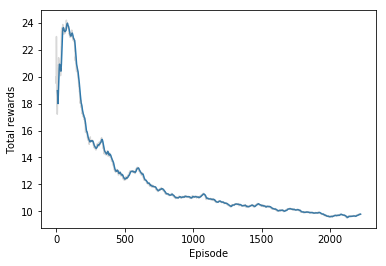

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

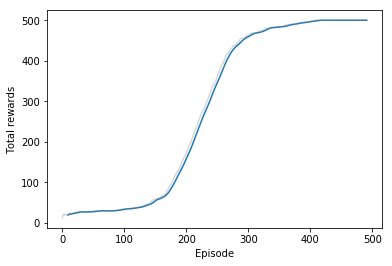

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

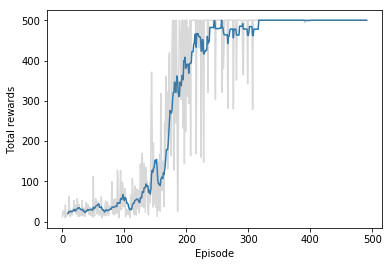

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.